# スパムメール コンペ EDA

- 配布されたデータを簡単に可視化・分析してみました．皆さんの参考になれば幸いです．  
- 意見・アイディア等ございましたらお気軽にコメントください．
- 動作はGoogle Colaboratory上で確認しましたが，必要なライブラリをインポートすればローカルでも動くと思います．

## 参考
このnotebook作成にあたり以下のサイトを参考にしました．
- [MultinomialNBを使ったbaseline(参考）](https://prob.space/competitions/spam_mail/discussions/cha_kabu-Postd207047dddb824a851d4) （cha_kabuさん）  
- [Twitter sentiment Extaction-Analysis,EDA and Model | Kaggle](https://www.kaggle.com/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model)

In [ ]:
!pip install transformers

In [2]:
%cd "/content/drive/My Drive/Colab Notebooks/Competition/ProbSpace/Spam mail"

/content/drive/My Drive/Colab Notebooks/Competition/ProbSpace/Spam mail


## ライブラリのインポート，ファイルのロードなど


In [3]:
from collections import Counter
import os
import random
import string

import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import seaborn as sns
import torch
from transformers import AutoTokenizer
from wordcloud import STOPWORDS, WordCloud

import warnings
warnings.filterwarnings('ignore')

In [4]:
SEED = 42
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

seed_everything(SEED)

In [5]:
TRAIN_FILE = "./data/train_data.csv"
TEST_FILE = "./data/test_data.csv"
MODEL_NAME = 'bert-base-uncased'

train_df = pd.read_csv(TRAIN_FILE)
test_df = pd.read_csv(TEST_FILE)
all_df = pd.concat([train_df, test_df])

not_spam = "0: not spam"
spam = "1: spam"

train_df.loc[train_df["y"] == 0, "y"] = not_spam
train_df.loc[train_df["y"] == 1, "y"] = spam

## データの確認

### 基本情報

In [6]:
print(train_df.shape)
print(test_df.shape)

(8878, 3)
(24838, 2)


trainデータは8878個，testデータは24838個です

In [7]:
print(train_df.info())
print()
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8878 entries, 0 to 8877
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        8878 non-null   int64 
 1   contents  8878 non-null   object
 2   y         8878 non-null   object
dtypes: int64(1), object(2)
memory usage: 208.2+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24838 entries, 0 to 24837
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        24838 non-null  int64 
 1   contents  24838 non-null  object
dtypes: int64(1), object(1)
memory usage: 388.2+ KB
None


trainデータ，testデータともに欠損値はありません

In [8]:
train_df

,id,contents,y
0,1,Subject: re : fw : willis phillips\r\ni just s...,0: not spam
1,2,Subject: re : factor loadings for primary curv...,0: not spam
2,3,Subject: re : meridian phone for kate symes\r\...,0: not spam
3,4,"Subject: re : october wellhead\r\nvance ,\r\nd...",0: not spam
4,5,Subject: california 6 / 13\r\nexecutive summar...,0: not spam
...,...,...,...
8873,8874,Subject: uk rpi model\r\nhi zimin !\r\nplease ...,0: not spam
8874,8875,Subject: new sitara desk request\r\nthis needs...,0: not spam
8875,8876,Subject: enterprise risk management\r\ndear vi...,0: not spam
8876,8877,Subject: re : the spreadsheet for talon deal\r...,0: not spam


In [9]:
test_df

,id,contents
0,1,Subject: re : weather and energy price data\r\...
1,2,Subject: organizational study\r\ngpg and eott ...
2,3,Subject: re [ 7 ] : talk about our meds\r\nske...
3,4,Subject: report about your cable service\r\nhi...
4,5,Subject: start date : 1 / 26 / 02 ; hourahead ...
...,...,...
24833,24834,Subject: savvy players would be wise to | 0 ad...
24834,24835,Subject: it ' s mariah from dating service\r\n...
24835,24836,Subject: meter 9699\r\njackie -\r\ni cannot fo...
24836,24837,Subject: presentation for cal berkeley\r\nhell...


### 重複の確認

In [10]:
train_df[["contents", "y"]].describe()

,contents,y
count,8878,8878
unique,8675,2
top,Subject: calpine daily gas nomination\r\n>\r\n...,0: not spam
freq,13,8707


contentsにおいてcountに比べてuniqueが少ないので一部重複があることがわかります  
最大で13個の重複があります

In [11]:
test_df[["contents"]].describe()

,contents
count,24838
unique,22147
top,Subject: \r\n
freq,51


同様にtestデータにもcontentsの重複があります  
特に`Subject: \r\n`は51個も含まれています

In [12]:
print('contentsが重複:', len(train_df[train_df.duplicated(subset=["contents"])]))
print('contentsとyがどちらも重複:', len(train_df[train_df.duplicated(subset=["contents", "y"])]))
train_df[train_df.duplicated(subset=["contents", "y"])]

contentsが重複: 203
contentsとyがどちらも重複: 203


,id,contents,y
624,625,Subject: calpine daily gas nomination\r\n>\r\n...,0: not spam
764,765,Subject: calpine daily gas nomination\r\n>\r\n...,0: not spam
855,856,Subject: fw : rahil jafry : carly fiorina tops...,0: not spam
865,866,Subject: enron japan weekly update\r\nhello ej...,0: not spam
994,995,Subject: attention : changes in remote access\...,0: not spam
...,...,...,...
8789,8790,Subject: entouch newsletter\r\nbusiness highli...,0: not spam
8840,8841,Subject: re : global risk management operation...,0: not spam
8869,8870,Subject: thanks for the offsite\r\nthank you f...,0: not spam
8872,8873,Subject: salary increase for logistics schedul...,0: not spam


trainデータにおいて，contentsが重複している数と，contentsとyがどちらも重複している数が一致しているので，同一テキストで異なるラベルが付与されたものはないことが確認できます

In [13]:
train_value_counts = train_df["contents"].value_counts()
train_value_counts[train_value_counts>=2]

Subject: calpine daily gas nomination\r\n>\r\nricky a . archer\r\nfuel supply\r\n700 louisiana , suite 2700\r\nhouston , texas 77002\r\n713 - 830 - 8659 direct\r\n713 - 830 - 8722 fax\r\n- calpine daily gas nomination 1 . doc                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

重複する（ユニークな）テキストは185個です  
13個もの重複があるテキストが1つあり，その他は2~3個の重複です

In [14]:
print('contentsが重複:', len(test_df[test_df.duplicated(subset=["contents"])]))
test_df[test_df.duplicated(subset=["contents"])]

contentsが重複: 2691


,id,contents
596,597,Subject: re : ink prices got you down ? 11956\...
871,872,Subject: hi paliourg get all pills . everythin...
924,925,Subject: save your money buy getting this thin...
1129,1130,Subject: select small - cap for astute investo...
1173,1174,Subject: caiso notification - tswg conference ...
...,...,...
24817,24818,Subject: fulton bank online security message\r...
24818,24819,Subject: request for transfer assistance\r\nfr...
24827,24828,"Subject: freedom - $ 1 , 021 , 320 . 00 per ye..."
24830,24831,Subject: delivery status notification ( failur...


In [15]:
test_value_counts = test_df["contents"].value_counts()
test_value_counts[test_value_counts>=2]

Subject: \r\n                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

testデータでは重複する（ユニークな）重テキストは2564個あります  
51個もの重複があるテキストが1つあり，その他は2~8個の重複です

trainデータとtestデータともに一定数の重複が見つかりましたが，これはcha_kabuさんのトピック，[元データセットについて（出典論文の訳）](https://prob.space/competitions/spam_mail/discussions/cha_kabu-Postbce066ef6a3182a536ad)で挙げられている論文の内容と異なるので，検証が必要そうです

### リークの確認

In [16]:
test_df[test_df["contents"].isin(train_df["contents"])]

,id,contents
0,1,Subject: re : weather and energy price data\r\...
43,44,Subject: ena analysts and associates\r\ni have...
239,240,Subject: board presentation - revised\r\nlouis...
523,524,Subject: overview of investor conference call\...
535,536,Subject: organization announcement\r\nenron pu...
...,...,...
24592,24593,Subject: gmm 21 sep 01\r\nplease find attached...
24626,24627,Subject: get debts off your back - time : 5 : ...
24683,24684,Subject: internet connectivity that beats the ...
24743,24744,Subject: enron mentions\r\nenron taps $ 3 bill...


trainデータとtestデータの両方に含まれるテキストが354個確認できます

### その他

In [17]:
all_df[all_df['contents'].str[0:9] != "Subject: "]

,id,contents,y


どのcontentsも最初の9文字は`Subject: `で始まることがわかります

In [18]:
all_df[~all_df['contents'].str.contains("\r\n")]

,id,contents,y


どのcontentsにも`\r\n`（改行コード）が少なくとも1つ含まれていることがわかります  
これはSubjectと本文を区切るための改行がどのcontentsにも含まれていることを示唆していると考えられます

## 分布の確認

ラベルごとの分布を確認します

In [19]:
top_labels = [not_spam, spam]

colors = ['#1f77b4', '#ff7f0e']

x_data = np.array([[7838, 17000], 
                   [train_df['y'].value_counts()[0], train_df['y'].value_counts()[1]]])
x_data = np.round(x_data / x_data.sum(axis=1, keepdims=True), 3)*100

y_data = ['test', 'train']

fig = go.Figure()

for i in range(0, len(x_data[0])):
    for xd, yd in zip(x_data, y_data):
        fig.add_trace(go.Bar(
            x=[xd[i]], y=[yd],
            orientation='h',
            marker=dict(
                color=colors[i],
                line=dict(color='rgb(248, 248, 249)', width=1)
            )
        ))

fig.update_layout(
    xaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=False,
        zeroline=False,
        domain=[0.15, 1]
    ),
    yaxis=dict(
        showgrid=False,
        showline=False,
        showticklabels=False,
        zeroline=False,
    ),
    barmode='stack',
    paper_bgcolor='rgb(248, 248, 255)',
    plot_bgcolor='rgb(248, 248, 255)',
    margin=dict(l=10, r=10, t=80, b=80),
    showlegend=False,
)

annotations = []

for yd, xd in zip(y_data, x_data):
    # labeling the y-axis
    annotations.append(dict(xref='paper', yref='y',
                            x=0.14, y=yd,
                            xanchor='right',
                            text=str(yd),
                            font=dict(family='Arial', size=14),
                            showarrow=False, align='right'))
    # labeling the first percentage of each bar (x_axis)
    annotations.append(dict(xref='x', yref='y',
                            x=xd[0] / 2, y=yd,
                            text=str(xd[0]) + '%',
                            font=dict(family='Arial', size=14,
                                      color='rgb(248, 248, 255)'),
                            showarrow=False))
    # labeling the first Likert scale (on the top)
    if yd == y_data[-1]:
        annotations.append(dict(xref='x', yref='paper',
                                x=xd[0] / 2, y=1.1,
                                text=top_labels[0],
                                font=dict(family='Arial', size=14),
                                showarrow=False))
    space = xd[0]
    for i in range(1, len(xd)):
            # labeling the rest of percentages for each bar (x_axis)
            annotations.append(dict(xref='x', yref='y',
                                    x=space + (xd[i]/2), y=yd,
                                    text=str(xd[i]) + '%',
                                    font=dict(family='Arial', size=14,
                                              color='rgb(248, 248, 255)'),
                                    showarrow=False))
            # labeling the Likert scale
            if yd == y_data[-1]:
                annotations.append(dict(xref='x', yref='paper',
                                        x=space + (xd[i]/2), y=1.1,
                                        text=top_labels[i],
                                        font=dict(family='Arial', size=14),
                                        showarrow=False))
            space += xd[i]

fig.update_layout(annotations=annotations)

fig.show()

trainデータは非スパム側にかなり偏っていることがわかります  
一方で，testデータはスパム側に偏っていることがわかります（公式の発表より）  
この不均衡に対してどう対処するかがこのコンペの鍵になりそうです

## トークン分割後の分析

contentsをトークン分割した後の分析をします
tokenizerとして`transformers`の`bert-base-uncased`用に学習されたtokenizerを使います  
また，`\r\n`などの改行コードは分割の段階で自動的に除去されるらしいです（詳しい仕様は要確認）

### トークン数

In [20]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
train_df['num_word'] = train_df['contents'].apply(lambda x:len(tokenizer.encode(x, truncation=False)))
test_df['num_word'] = test_df['contents'].apply(lambda x:len(tokenizer.encode(x, truncation=False)))
train_df.head()

,id,contents,y,num_word
0,1,Subject: re : fw : willis phillips\r\ni just s...,0: not spam,96
1,2,Subject: re : factor loadings for primary curv...,0: not spam,391
2,3,Subject: re : meridian phone for kate symes\r\...,0: not spam,98
3,4,"Subject: re : october wellhead\r\nvance ,\r\nd...",0: not spam,168
4,5,Subject: california 6 / 13\r\nexecutive summar...,0: not spam,659


In [21]:
print(f'longer than 512 (train): {len(train_df[train_df["num_word"]>512].index)} / {len(train_df.index)}')
print(f'longer than 512 (test):  {len(test_df[test_df["num_word"]>512].index)} / {len(test_df.index)}')

longer than 512 (train): 1628 / 8878
longer than 512 (test):  4380 / 24838


トークン数が512を超えるテキストがかなりの割合で存在します  
BERTなどの，入力トークン数に制限があるモデルを使用する場合は工夫が必要そうです

### トークン数の分布

In [22]:
hist_data = [train_df["num_word"][train_df["num_word"]<3000],\
             test_df["num_word"][test_df["num_word"]<3000]]
group_labels = ["train", "test"]
fig = ff.create_distplot(hist_data, group_labels, show_curve=True)
fig.update_layout(title_text='Distribution of Number of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue",
)
fig.show()

trainデータとtestデータにおけるトークン数の分布です  
trainデータとtestデータでトークン数の分布に違いはなさそうです

In [23]:
hist_data = [train_df.loc[train_df["y"]==not_spam, "num_word"][train_df["num_word"]<2000],\
             train_df.loc[train_df["y"]==spam, "num_word"][train_df["num_word"]<2000]]
group_labels = ["not spam", "spam"]
fig = ff.create_distplot(hist_data, group_labels, show_curve=True)
fig.update_layout(title_text='Distribution of Number of words')
fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue"
)
fig.show()

スパムと非スパムにおけるトークン数の分布です  
スパムにおけるトークン数の分布が不自然に見えますが，縦軸が割合を表しており，スパムのサンプル数が少ないので1サンプルが占める割合が大きくなることを踏まえると，スパムと非スパムの間に分布の違いはないと言えるでしょう

### 単語出現頻度

単語ごとの出現頻度を可視化します

In [24]:
train_df['word_list'] = train_df['contents'].apply(lambda x: tokenizer.tokenize(x))
top = Counter([item for sublist in train_df['word_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,-,161488
1,.,145953
2,",",118498
3,the,94052
4,:,69049
5,to,67404
6,/,66664
7,and,43695
8,of,40371
9,en,34759


In [25]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in contents', orientation='h', 
             width=700, height=700, color='Common_words')
fig.show()

普遍的に登場する単語（the, and, ofなど）が多く登場していることがわかります  
このままでは特徴を掴みづらいのでストップワードを除去します  
（逆に，ここで上位に上がっている`##ron`や`en`は相当多く出現していると言えそうです．これは[元データセットについて（出典論文の訳）](https://prob.space/competitions/spam_mail/discussions/cha_kabu-Postbce066ef6a3182a536ad)で紹介されている内容と一致していそうです）

In [26]:
nltk.download('stopwords')
stopwords_list = set(stopwords.words('english') + list(string.punctuation))
stopwords_list
def remove_stopword(x):
    return [y for y in x if y not in stopwords_list]
train_df['word_list'] = train_df['word_list'].apply(lambda x:remove_stopword(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [27]:
top = Counter([item for sublist in train_df['word_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,en,34759
1,##ron,32103
2,##t,21659
3,ec,18433
4,subject,15162
5,##s,13695
6,##u,11654
7,ho,8983
8,2001,8274
9,2000,7293


In [28]:
fig = px.bar(temp, x="count", y="Common_words", title='Commmon Words in contents', orientation='h', 
             width=700, height=700, color='Common_words')
fig.show()

1位と2位で`enron`，3位と4位で`ect`が確認できます．この辺りは分割方法に工夫の余地がありそうです

In [29]:
top = Counter([item for sublist in train_df['word_list'][train_df["y"]==not_spam] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
fig = px.bar(temp, x="count", y="Common_words", title=f'Commmon Words in "not spam"', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

非スパムにおける単語登場頻度です．trainデータにおいて非スパムが98%を占めるので，trainデータ全体の分布との差異があまりありません

In [30]:
top = Counter([item for sublist in train_df['word_list'][train_df["y"]==spam] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words','count']
fig = px.bar(temp, x="count", y="Common_words", title=f'Commmon Words in "spam"', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

スパムの単語登場頻度です．こちらは判断が難しそうです．`##o``##l``##e`などのアルファベット1文字に分解されているトークンが多いので，未知語やデタラメな文字列が多いと考えられそうです．`http`や`com`が上位に来ている点も注目するべきでしょう

### ラベルごとのユニークな単語

片方のラベルにしか登場しない単語を可視化してみます

In [31]:
def words_unique(label, numwords, raw_words):
    '''
    Input:
        label - spam or not spam;
        numwords - how many specific words do you want to see in the final result; 
        raw_words - list for item in train_df['word_list']:
    Output: 
        dataframe giving information about the name of the specific ingredient and how many times it occurs in the chosen cuisine (in descending order based on their counts)..

    '''
    all_other = set()
    for item in train_df[train_df.y != label]['word_list']:
        for word in set(item):
            all_other.add(word)
    
    unique_words = set([x for x in raw_text if x not in all_other])
    
    counter = Counter()
    
    for item in train_df[train_df.y == label]['word_list']:
        for word in item:
            counter[word] += 1
    
    for word in list(counter):
        if word not in unique_words:
            del counter[word]
    
    unique_words_df = pd.DataFrame(counter.most_common(numwords), columns = ['words','count'])
    
    return unique_words_df

In [32]:
raw_text = set([word for word_list in train_df['word_list'] for word in word_list])

In [33]:
unique_not_spam = words_unique(not_spam, 20, raw_text)
print("The top 20 unique words in 'not spam':")
unique_not_spam.style.background_gradient(cmap='Greens')

The top 20 unique words in 'not spam':


,words,count
0,cc,4911
1,vince,4739
2,houston,3027
3,##yne,2875
4,##inski,2762
5,kam,2753
6,71,2232
7,mm,2010
8,john,1964
9,hp,1913


非スパムにユニークな単語です．`houston` `california`などの地名や`schedule` `chief`などの仕事で使用する単語が確認できます．

In [34]:
unique_spam= words_unique(spam, 20, raw_text)
print("The top 20 unique words in 'spam':")
unique_spam.style.background_gradient(cmap='Reds')

The top 20 unique words in 'spam':


,words,count
0,ion,13
1,php,11
2,##sphere,10
3,penis,7
4,##cion,6
5,portraits,5
6,orgasm,5
7,##wear,5
8,pali,5
9,bbc,5


スパムにユニークな単語です．`##wear`や`##mobile`は企業名の一部でしょうか？その他下ネタ系の単語が確認できます

### ワードクラウド

最後にワードクラウドを見ていきます  
こちらはcha_kabuさんの[MultinomialNBを使ったbaseline(参考）](https://prob.space/competitions/spam_mail/discussions/cha_kabu-Postd207047dddb824a851d4)を~~パクら~~参考にさせていただきました．
ほとんどcha_kabuさんのものと同様ですが，Tokenizerが違うので一応見てみます

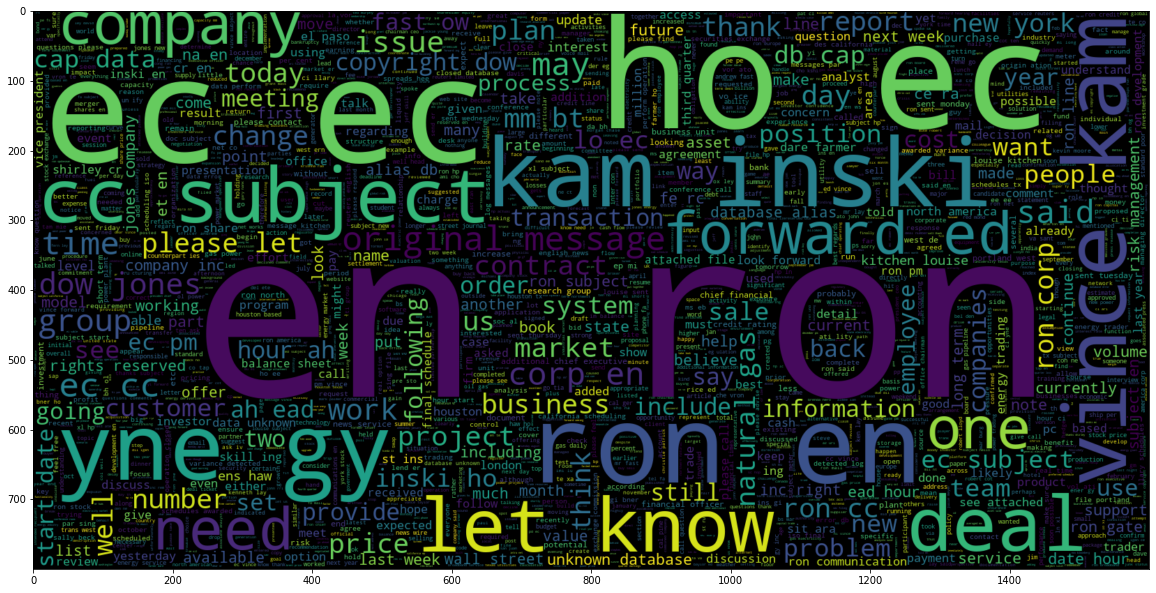

In [35]:
not_spam_words = []
for item in train_df[train_df.y == not_spam]['word_list']:
    not_spam_words += item
not_spam_words = ' '.join(not_spam_words)
plt.figure(figsize=(20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = STOPWORDS).generate(not_spam_words)
plt.imshow(wc, interpolation="bilinear")

上記で見たものと同様に`enron`などが確認できます

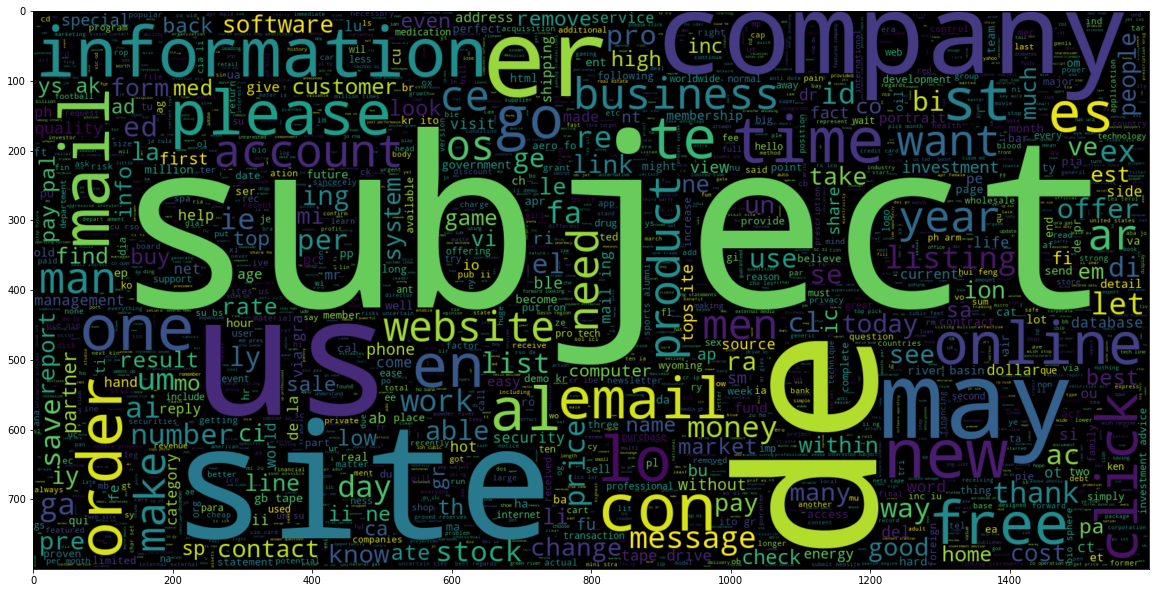

In [36]:
spam_words = []
for item in train_df[train_df.y == spam]['word_list']:
    spam_words += item
spam_words = ' '.join(spam_words)
plt.figure(figsize=(20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800, stopwords = STOPWORDS).generate(spam_words)
plt.imshow(wc, interpolation="bilinear")

`subject`が目につきますが，その他に特筆すべき点は見受けられません

意見・アイディア等ありましたがお気軽にコメントいただけると嬉しいです．  
（ついでにupvoteもしていただけるとありがたいです！）